<a href="https://colab.research.google.com/github/teaminii/MachineLearning/blob/main/Lec15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)


     |████████████████████████████████| 591.8 MB 661 bytes/s 
     |████████████████████████████████| 21.0 MB 26.0 MB/s 
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 197 kB/s 
     |████████████████████████████████| 23.3 MB 17.5 MB/s 
     |████████████████████████████████| 22.1 MB 55.8 MB/s 
     |████████████████████████████████| 22.1 MB 60.7 MB/s 
     |████████████████████████████████| 17.4 MB 76.5 MB/s 
     |████████████████████████████████| 17.3 MB 30 kB/s 
     |████████████████████████████████| 12.8 MB 31.4 MB/s 
     |████████████████████████████████| 12.7 MB 8.8 MB/s 
     |████████████████████████████████| 11.8 MB 24.7 MB/s 
     |████████████████████████████████| 5.9 MB 20.9 MB/s 
     |████████████████████████████████| 6.6 MB 25.6 MB/s 
     |████████████████████████████████| 6.6 MB 26.2 MB/s 
     |████████████████████████████████| 4.0 MB 39.3 MB/s 
     |████████████████████████████████| 10.2 MB 25.7 MB/s 
   

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


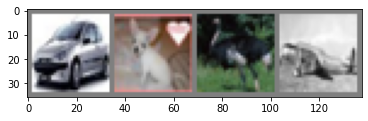

  car  dog birdplane
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([1, 5, 2, 0])


In [6]:
############## Data Checking

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join('%5s'%classes[labels[j]] for j in range(4)))

print(type(images), images.shape)
print(type(labels),labels.shape, labels)

In [7]:

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
          
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x
      
net = MLP(3072, 10, 100, 4, 'relu')

In [8]:
 ## Define a Loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [10]:
# ===========Training
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs.shape)
        inputs = inputs.view(-1,3072)
        #print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')



[1,  2000] loss : 1.912
[1,  4000] loss : 1.769
[1,  6000] loss : 1.713
[1,  8000] loss : 1.668
[1, 10000] loss : 1.620
[2,  2000] loss : 1.552


KeyboardInterrupt: ignored

In [11]:
#============Measure Test Accuratcy=================#
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1,3072)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 44 %


In [12]:
#===============Measure Val Accuracy / Val Loss ================#
correct = 0
total = 0
val_loss = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.view(-1,3072)
        # calculate outputs by running images through the network
        outputs = net(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        #print(loss)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(valloader)
    acc = 100*correct/total

print('Accuracy of the network on the 10000 test images: {:2.2f}% Loss :  {:2.2f}' .format(acc,val_loss))

Accuracy of the network on the 10000 test images: 43.82% Loss :  1.57


In [14]:
#========= experiment
def experiment(args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  

        # ================== Train 
        net.train()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            inputs, labels = data
            inputs = inputs.view(-1, 3072)
    
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:  
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                

        # ================ Validation 
        net.eval()
        correct = 0
        total = 0
        val_loss = 0 
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))


    # =================== Evaluation 
    net.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc
    

In [17]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2

experiment(args)


MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.296
[1,  4000] loss: 2.108
[1,  6000] loss: 1.933
[1,  8000] loss: 1.804
[1, 10000] loss: 1.716
Epoch 0, Train Loss: 19713.733910381794, Val Loss: 1.7302531636834144, Val Acc: 38.22
[2,  2000] loss: 1.654
[2,  4000] loss: 1.639
[2,  6000] loss: 1.604
[2,  8000] loss: 1.568
[2, 10000] loss: 1.560
Epoch 1, Train Loss: 16047.546660482883, Val Loss: 1.6042166769385338, Val Acc: 43.13


(16047.546660482883, 1.6042166769385338, 43.13, 44.06)